# Discovering MOABB

In this first notebook, we will use Motor Imagery (MI) BCI as first entry point to discover MOABB. We choose the dataset 2a from BCI Competition IV, a motor imagery task. We will use a CSP to enhance the signal-to-noise ratio of the EEG epochs and a LDA to classify these signals.

Please make sure you have verified your installation with the notebook `0_Minischool_Verify_Installation`.

## Downloading datasets

We will use the dataset 2a from BCI Competition IV as an example here. You could explicitely download the dataset with the following code.


In [1]:
from moabb.datasets import BNCI2014_001

dataset = BNCI2014_001()
dataset.download()

You could get the data from a specific subject, or a specific set of subjects. If you want to ge the data from the first subject:

In [2]:
subj = 1
data = dataset.get_data(subjects=[subj])
data

{1: {'0train': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>},
  '1test': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>}}}

The data are stored in nested dict, the first is the subject (here `1` as we have only selected one subject) , the second is the session (here `0train` or `1test`) and the runs (here from `0` to `5`).

In the MOABB terminology, the session are meant to stored different recordings of the same subject, for example across several days, while runs are more like blocks of a running experiment.

If we want to get the data from the first subject, 0train and 0:

In [3]:
subject, session, run = 1, "0train", "0"
raw = data[subject][session][run]

raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,25 points
Good channels,"22 EEG, 3 EOG, 1 Stimulus"
Bad channels,None
EOG channels,"EOG1, EOG2, EOG3"
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


## Exploring the data with MNE 

The raw object is a MNE file. All the possibilities opened by this toolbox are available, let's see some examples!

It is easy to get a visualization of the electrode positioning:

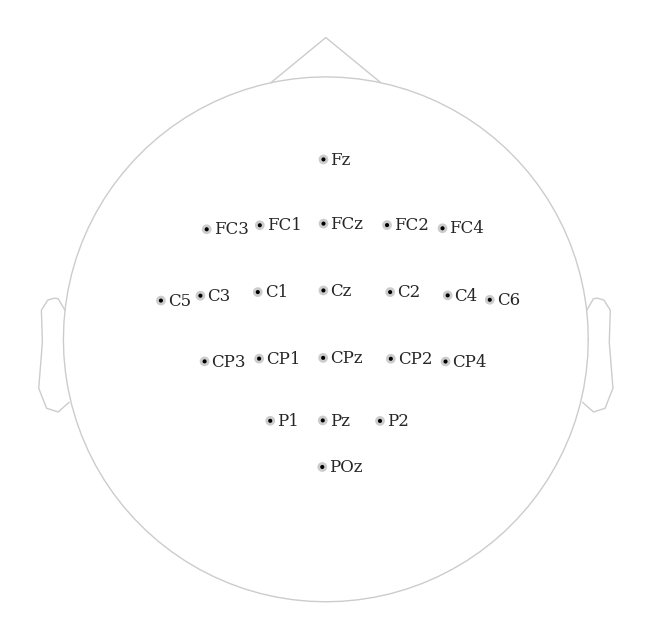

In [4]:
_ = raw.plot_sensors(show_names=True)

Or visualize EEG signal:

Using matplotlib as 2D backend.


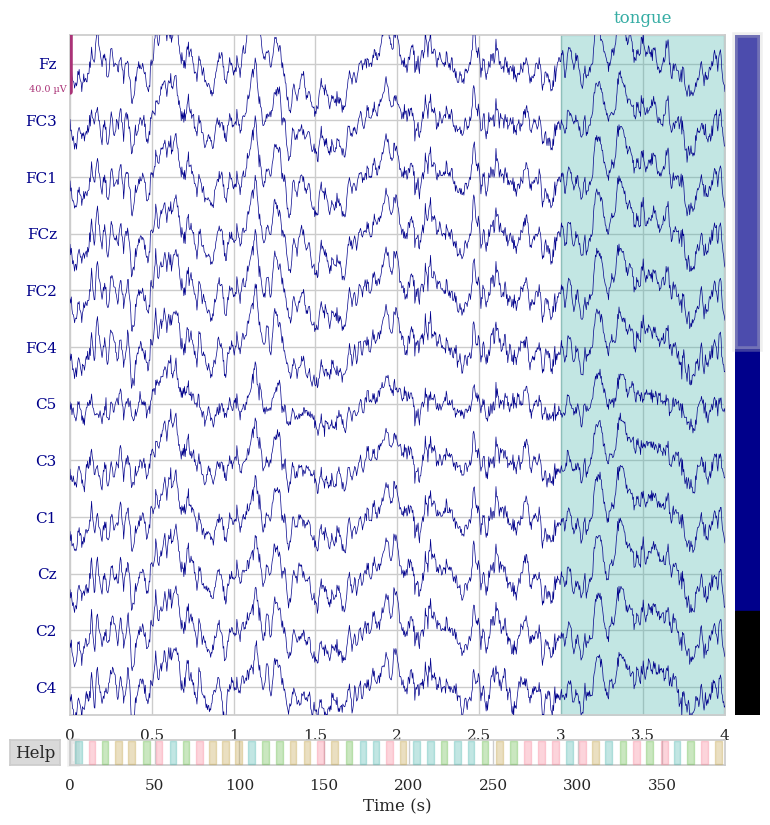

In [5]:
_ = raw.plot(duration=4, n_channels=12, color={'eeg':'darkblue'})

There are lots tools for investigating EEG, such spectral domain:

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/var/folders/d4/_4q888f9053cl142j5r3tmy00000gq/T/ipykernel_51556/769808809.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  _ = raw.plot_psd(fmin=4., fmax=35, picks=['eeg'])
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


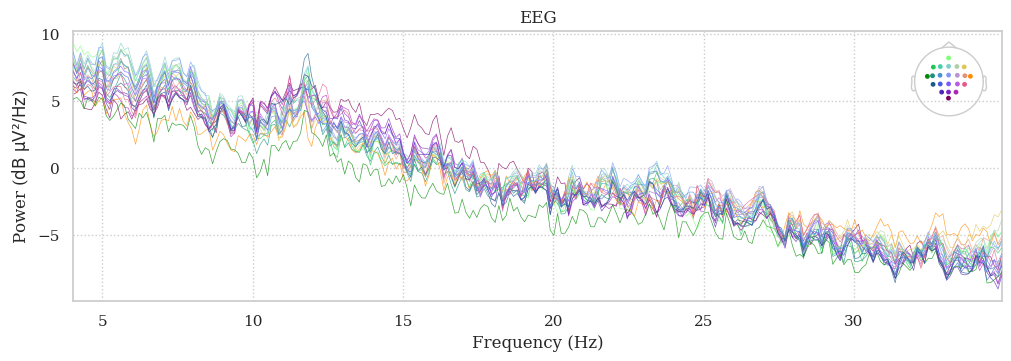

In [6]:
_ = raw.plot_psd(fmin=4., fmax=35, picks=['eeg'])

## Running a benchmark with MOABB

1. Choose a paradigm, we will restrict the left- and right-hand classification on the dataset 2a of BCI Competition IV

In [7]:
from moabb.paradigms import LeftRightImagery

paradigm = LeftRightImagery()
datasets = [BNCI2014_001()]

2. Create a machine learning pipeline (following a scikit learn style). For this example, we will use a Common Spatial Patterns (CSP) to enhance the signal and reduce the dimensionality, and a Linear Discriminant Analysis (LDA) for classification.

In [8]:
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pipeline = make_pipeline(CSP(n_components=8), LDA())
pipelines = {'csp+lda': pipeline}

3. Define an evaluation. Here we will use a within-session cross-validation, using 5 folds. You need to define the paradigm and the chosen dataset for the evaluation.

In [9]:
from moabb.evaluations import WithinSessionEvaluation

evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=False)

We could now run the evaluation by evaluating the chosen pipelines (here CSP+LDA)

In [ ]:
results_datasets = evaluation.process(pipelines) 

In [12]:
results_datasets.to_csv("results.csv")

The dataset are store in a [pandas DataFrame](https://pandas.pydata.org/), this structure is similar to an excel file (and could be exported as xls!).

Using tools like [seaborn](seaborn.pydata.org/), it is easy to plot nice graphs from those results.

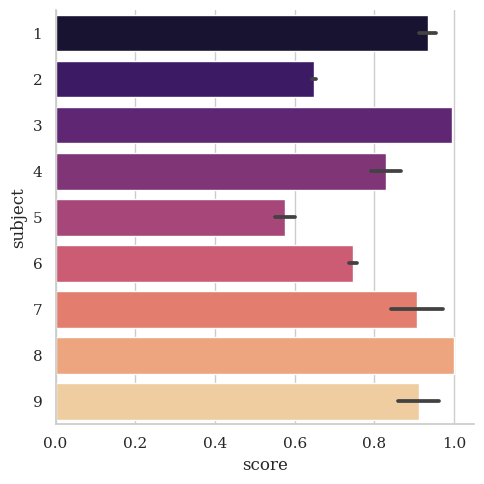

In [14]:
import seaborn as sns

sns.catplot(kind='bar', x="score", y="subject", hue=None, data=results_datasets, palette="magma")